# P4 - 01 - Exploratory notebook

The city of Seattle wants to predict buildings CO2 emissions and energy consumption, using the data available on the construction permit. We can use the two energy benchmarking files in order to create some models for these predictions : https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking

This notebook is only the first part of the work (exploratory analysis). For the modeling work, go on the second one.

1. **[Loading and understanding data](#1)**
    1. [Loading files](#1)
    2. [Comparing columns](#1.2)
    3. [Merging files](#1.3)
2. **[Exploring the dataset](#2)**
    1. [Input qualitative features univariate analysis](#2)
    2. [Input quantitative features univariate analysis](#2.2)
    3. [Targets univariate analysis](#2.3)
    4. [Multivariate analysis](#2.4)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import chi2_contingency

from common_functions import *

In [2]:
# Display options 
sns.set_theme()

MAIN_CHART_COLOR = 'darkorange'
OUTPUT_CHART_COLOR = 'lightgreen'
TARGET_COLORS = ['#2498c1', '#075792']
TARGET_SECONDARY_COLORS = ['#CA7C29', '#C20A0A']

<a name="1"></a>
# 1. Loading and understanding data
## 1.1 Loading files

In [3]:
data_2015 = pd.read_csv('./data/2015-building-energy-benchmarking.csv', sep=',')
data_2016 = pd.read_csv('./data/2016-building-energy-benchmarking.csv', sep=',')

In [4]:
print("2015 data shape : " + str(data_2015.shape))
print("2016 data shape : " + str(data_2016.shape))

2015 data shape : (3340, 47)
2016 data shape : (3376, 46)


Both files contains approximately the same number of rows and columns, so they should be very similar.

<a name="1.2"></a>
## 1.2 Comparing columns
Let dive into the detail of files columns to understand better where the differences are.

In [5]:
def compare_columns(file_2015, file_2016):
    '''
    Return a DF with one line per column and 2 boolean columns to know if they belong to 2015/2016/both
    :param file_2015: file containing 2015 data
    :param file_2016: file containing 2016 data
    :return: DataFrame
    '''
    columns_2015 = data_2015.columns.to_list()
    columns_2016 = data_2016.columns.to_list()
    columns_similarities = pd.DataFrame(sorted(columns_2015 + columns_2016)).set_index(0)

    for column in columns_similarities.index.to_list():
        columns_similarities.loc[column, '2015'] = True if column in columns_2015 else False
        columns_similarities.loc[column, '2016'] = True if column in columns_2016 else False

    # Removing duplicated indexes
    columns_similarities = columns_similarities[~columns_similarities.index.duplicated(keep='first')]

    return columns_similarities

In [6]:
# Displaying only difference between columns
columns_similarities = compare_columns(data_2015, data_2016)

print("List of all columns different between each file : ")
columns_similarities[columns_similarities['2015'] != columns_similarities['2016']]

List of all columns different between each file : 


2015   2016
0                                                               
2010 Census Tracts                                   True  False
Address                                             False   True
City                                                False   True
City Council Districts                               True  False
Comment                                              True  False
Comments                                            False   True
GHGEmissions(MetricTonsCO2e)                         True  False
GHGEmissionsIntensity                               False   True
GHGEmissionsIntensity(kgCO2e/ft2)                    True  False
Latitude                                            False   True
Location                                             True  False
Longitude                                           False   True
OtherFuelUse(kBtu)                                   True  False
SPD Beats                                            True  False
Seattle Police Department Micro Community Polic...   True  False
State                                               False   True
TotalGHGEmissions                                   False   True
Zip Codes                                            True  False
ZipCode                                             False   True

Now we are going to compare the mean values of all numerical features, in order to decide if we keep only the 2016 values, or if we have to calculate a mean value between both files.

<AxesSubplot:title={'center':'Numerical features values difference between 2016 and 2015'}>

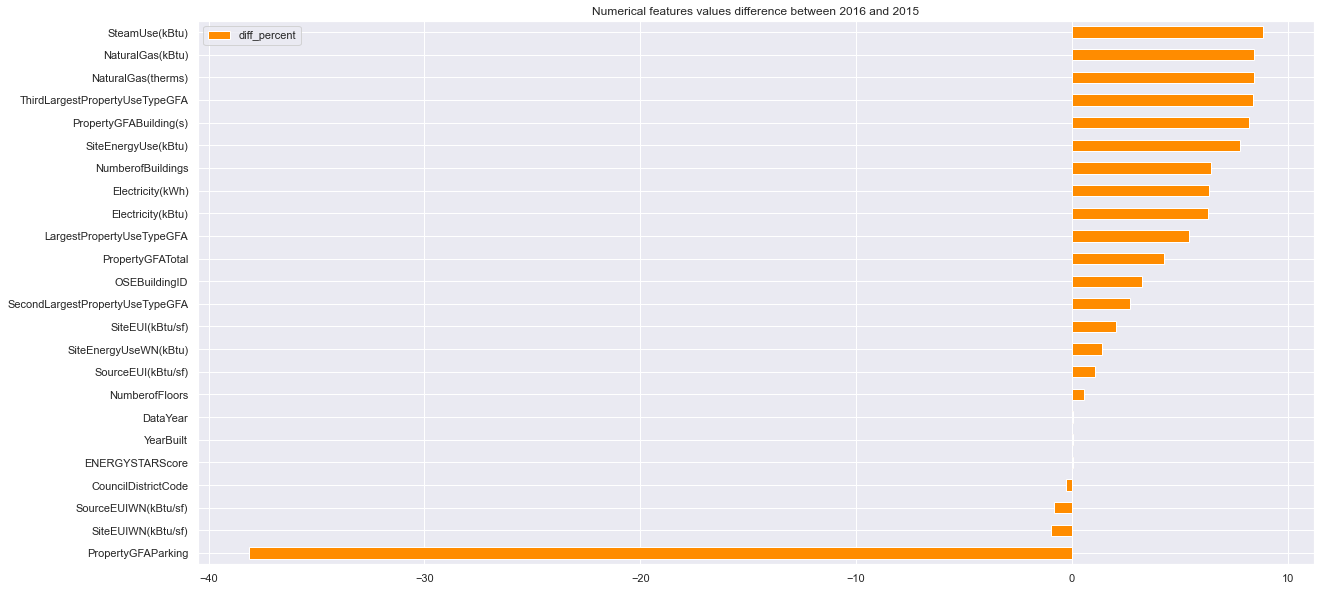

In [7]:
mean_diff = data_2015.describe().loc['mean'].to_frame()\
    .merge(data_2016.describe().loc['mean'].to_frame(), left_index=True, right_index=True)

mean_diff['diff_percent'] = 100 * ((mean_diff['mean_y'] - mean_diff['mean_x']) / mean_diff['mean_y'])

mean_diff.sort_values(by='diff_percent', ascending=True)\
    .filter(['diff_percent'])\
    .plot(kind='barh', 
          figsize=(20,10), 
          color=MAIN_CHART_COLOR, 
          title="Numerical features values difference between 2016 and 2015")

<a name="1.3"></a>
## 1.3 Merging files
We are going to use the most recent file (2016) and add to it all the building of 2015 (if they are not already present) using the column `OSEBuildingID`.

In [8]:
data = merge_both_files(data_2015, data_2016)
print("Total number of lines added from 2015 file to 2016 : " + str(len(data[data['DataYear'] == 2015])))

Total number of lines added from 2015 file to 2016 : 56


<a name="2"></a>
# 2. Exploring the dataset
## 2.1 Input qualitative features univariate analysis
### Filling percentages

In [9]:
data_exploration = data.copy()

<BarContainer object of 29 artists>

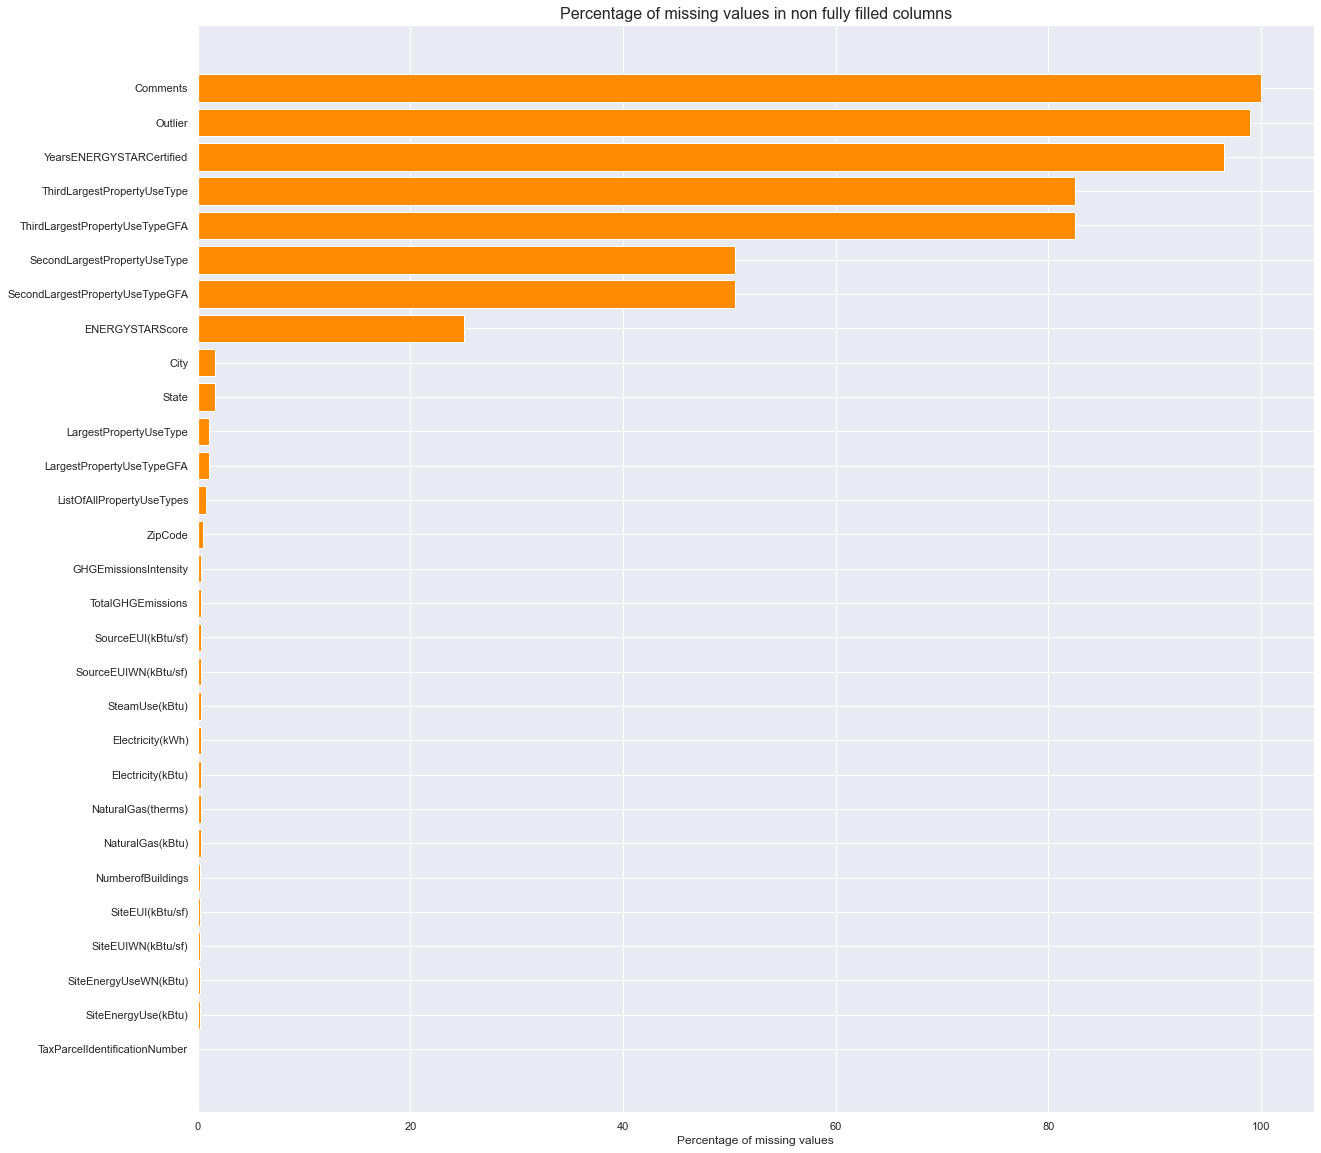

In [10]:
filling_percentages = data_exploration.isna().sum(axis=0).to_frame()
filling_percentages.columns = ['percentage']
filling_percentages = 100 * filling_percentages / len(data_exploration)
filling_percentages = filling_percentages[filling_percentages['percentage'] > 0].sort_values(by='percentage', ascending=True)

plt.figure(figsize=(20,20))
plt.title("Percentage of missing values in non fully filled columns", fontsize=16)
plt.xlabel("Percentage of missing values")
plt.barh(y=filling_percentages.index, width=filling_percentages['percentage'], color=MAIN_CHART_COLOR)

### Building Types

In [11]:
def show_categories_barh(column_name, color=MAIN_CHART_COLOR, figsize=(13,7), title=None, ax=None):
    if ax == None:
        fig = plt.figure(figsize=figsize)
        ax = plt.gca()
        
    plot_data = data_exploration.copy()
    ax.set_title(title, fontsize=16)
    plot_data[column_name].fillna('Unknown')
    plot_data[column_name].value_counts().sort_values(ascending=True).plot(kind='barh', color=color, ax=ax)

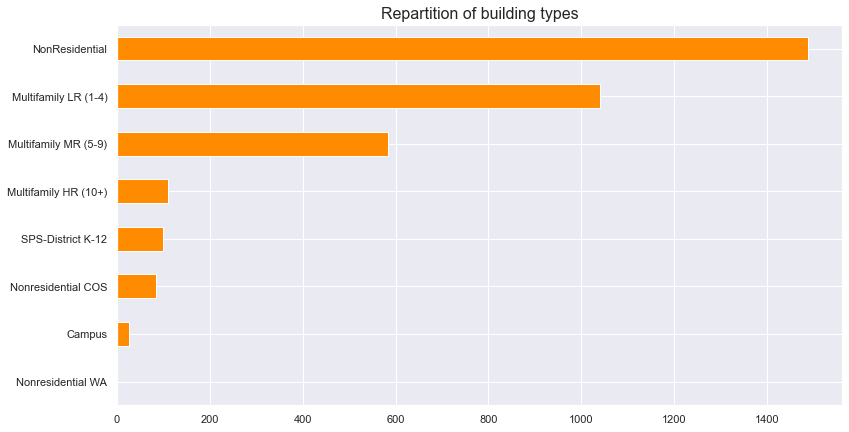

In [12]:
# Calculating the mean number of buildings of each types on both years
show_categories_barh('BuildingType', title='Repartition of building types')

We can see that, when removing the residential values, almost all building types are under "NonResidential" category. So **we have no interest in keeping the BuildingType feature**.

### Primary Property Type

<AxesSubplot:title={'center':'Primary property types after grouping'}>

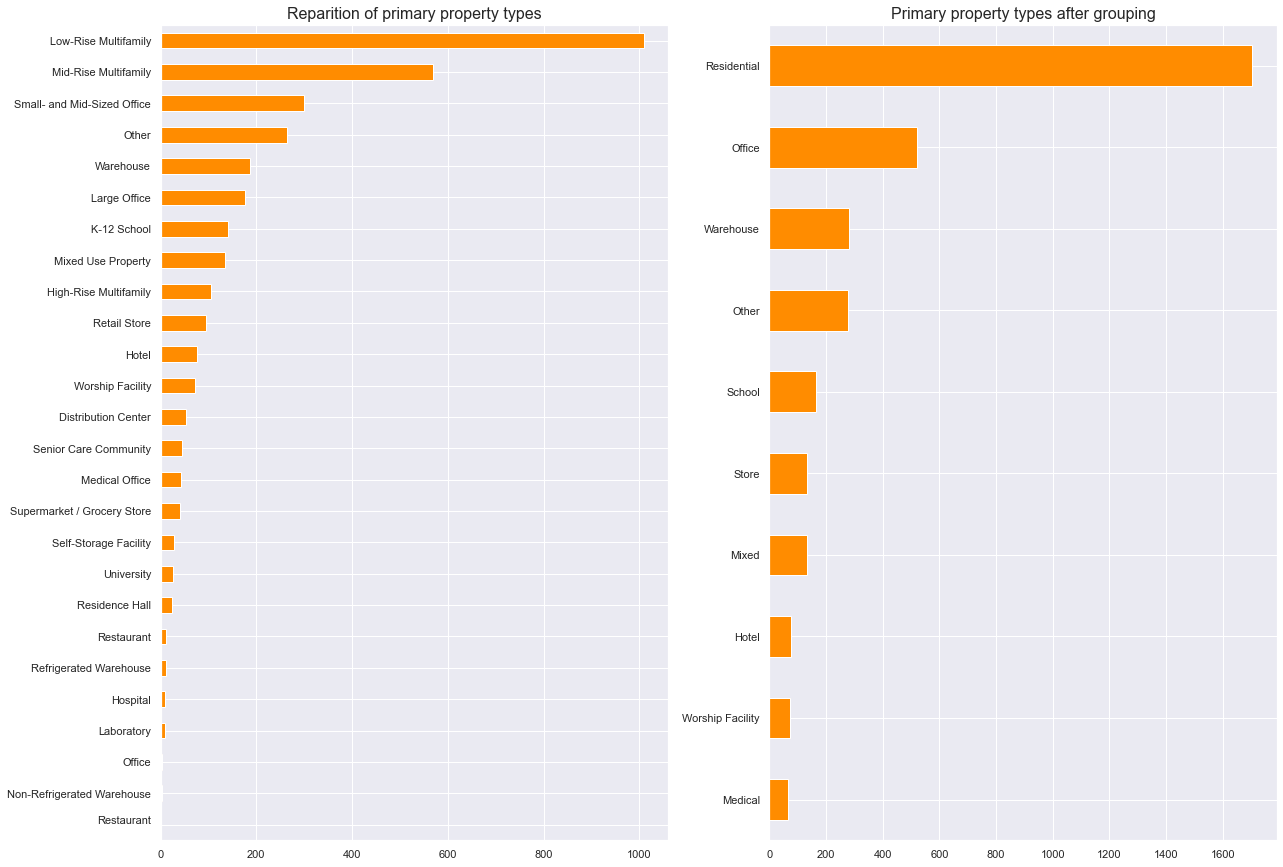

In [13]:
fig, axes = plt.subplots(figsize=(20, 15), ncols=2)
show_categories_barh('PrimaryPropertyType',
                     figsize=(13,13),
                     title='Reparition of primary property types',
                     ax=axes[0])

axes[1].set_title("Primary property types after grouping", fontsize=16)
grouped_data = group_primary_property_types(data_exploration)
grouped_data['PrimaryPropertyType']\
    .value_counts()\
    .sort_values(ascending=True)\
    .plot(kind='barh', color='darkorange', ax=axes[1])

### Property Use Types

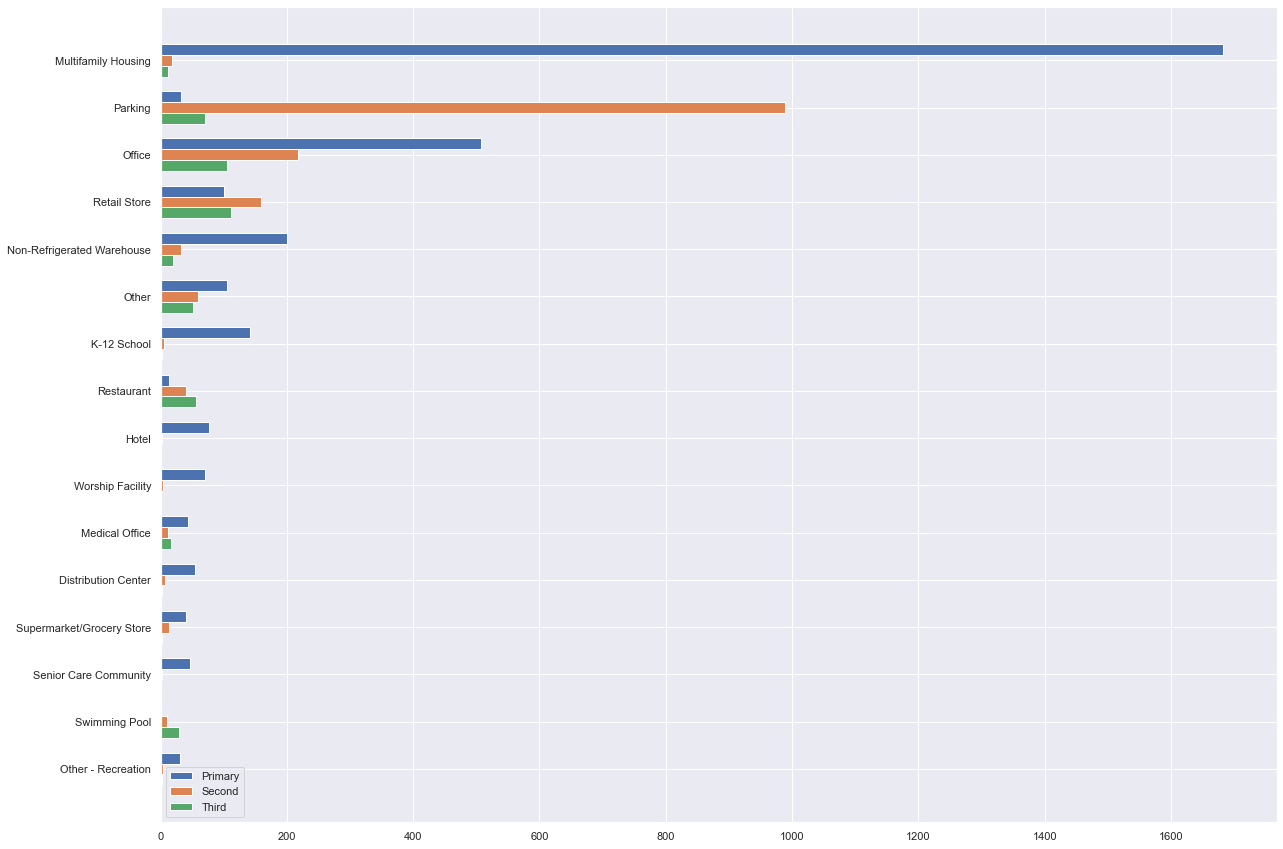

In [14]:
# Using another dataframe to fill nan values
data_ut_expl = data_exploration[['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']].copy()
data_ut_expl.fillna('Unknown', inplace=True)

# Preparing plot values
primary_use_type = data_ut_expl['LargestPropertyUseType'].value_counts().sort_values(ascending=False).to_frame()
secondary_use_type = data_ut_expl['SecondLargestPropertyUseType'].value_counts().to_frame()
third_use_type = data_ut_expl['ThirdLargestPropertyUseType'].value_counts().to_frame()

plot_data = primary_use_type\
    .merge(secondary_use_type, left_index=True, right_index=True, how='outer')\
    .merge(third_use_type, left_index=True, right_index=True, how='outer')\
    .fillna(0)

plot_data['TotalUses'] = plot_data['LargestPropertyUseType'] + plot_data['SecondLargestPropertyUseType'] + plot_data['ThirdLargestPropertyUseType']

# Skipping the "unknown" values (most represented)
plot_data
plot_data = plot_data.sort_values(by='TotalUses', ascending=True)[-17:-1]

fig, ax = plt.subplots(figsize=(20,15))
y = np.arange(len(plot_data.index))  # the label locations
height = 0.23  # the width of the bars
rects1 = ax.barh(y + height, plot_data['LargestPropertyUseType'], height, label='Primary')
rects2 = ax.barh(y, plot_data['SecondLargestPropertyUseType'], height, label='Second')
rects3 = ax.barh(y - height, plot_data['ThirdLargestPropertyUseType'], height, label='Third')
ax.set_yticks(np.arange(len(plot_data)))
ax.set_yticklabels(plot_data.index.tolist())
ax.legend()

### Neighborhood

<BarContainer object of 13 artists>

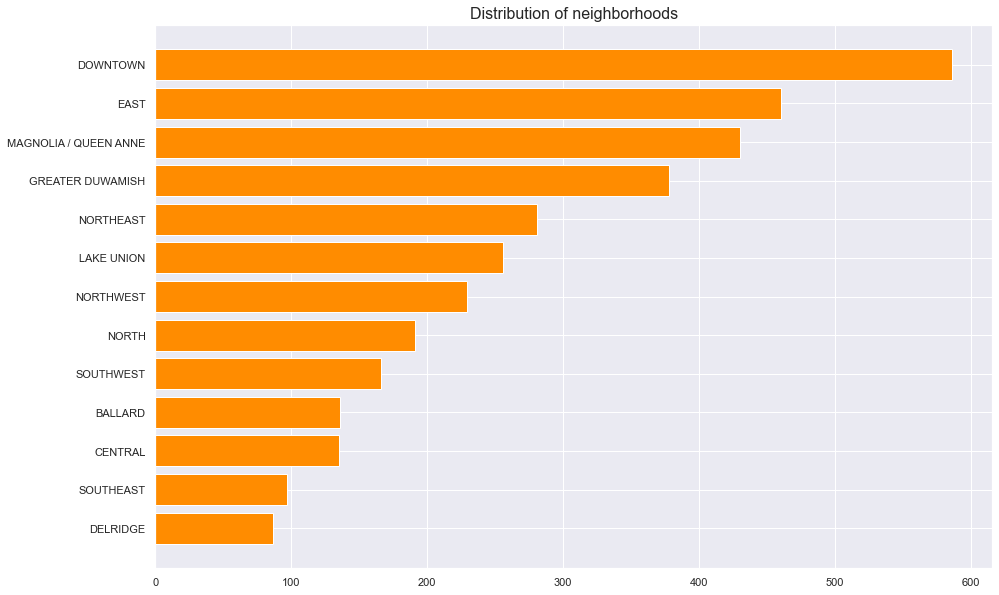

In [15]:
# Some of neighborhoods values are duplicates with different cases
data_exploration['Neighborhood'] = data_exploration['Neighborhood'].str.upper()
data_exploration.loc[data_exploration['Neighborhood'] == 'DELRIDGE NEIGHBORHOODS', 'Neighborhood'] = "DELRIDGE"

neighborhood_vc = data_exploration['Neighborhood'].value_counts().sort_values(ascending=True)

plt.figure(figsize=(15,10))
plt.title('Distribution of neighborhoods', fontsize=16)
plt.barh(y=neighborhood_vc.index, width=neighborhood_vc.values, color=MAIN_CHART_COLOR)

### Council District Codes

<BarContainer object of 7 artists>

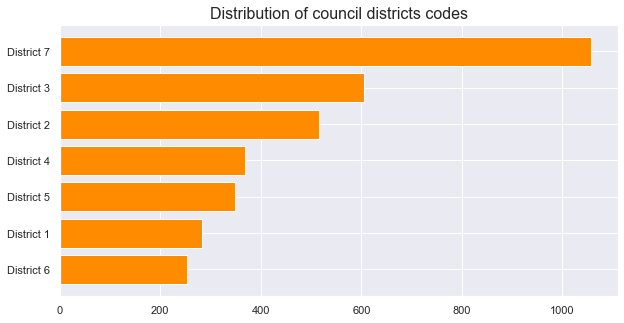

In [16]:
cdc_vc = data_exploration['CouncilDistrictCode'].value_counts().sort_values(ascending=True)

# Renaming the index to avoid auto-sorting of barh
new_indexes = []
for index in cdc_vc.index:
    new_indexes.append("District " + str(index))

plt.figure(figsize=(10,5))
plt.title('Distribution of council districts codes', fontsize=16)
plt.barh(y=new_indexes, width=cdc_vc.values, color=MAIN_CHART_COLOR)

### Street type
The idea here is to extract the street type to give it to the models, because biggest ones shoult contains more big buildings. Maybe it can provide us more information about it.

<BarContainer object of 5 artists>

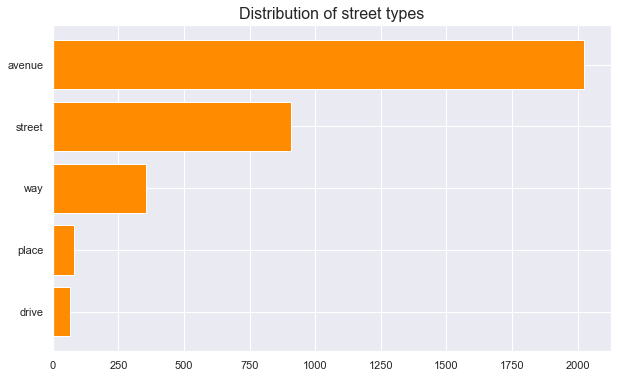

In [17]:
data_exploration = add_street_type_column(data_exploration)
street_types = data_exploration['StreetType'].value_counts().sort_values(ascending=True)

plt.figure(figsize=(10,6))
plt.title("Distribution of street types", fontsize=16)
plt.barh(y=street_types.index, width=street_types.values, color=MAIN_CHART_COLOR)

<a name="2.2"></a>
## 2.2 Input quantitative features univariate analysis

### Building year / age

<AxesSubplot:title={'center':'Buildings ages distribution'}, ylabel='Frequency'>

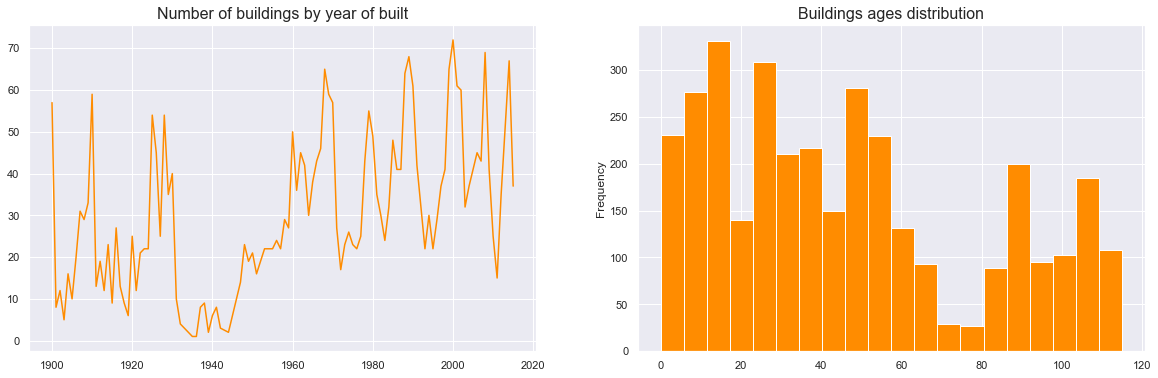

In [18]:
work_data = data_exploration.copy()

# We can convert year to an age
last_year = work_data['YearBuilt'].max()
work_data['BuildingAge'] = last_year - work_data['YearBuilt']

# Plotting constructions by year of built
fig, axes = plt.subplots(figsize=(20,6), ncols=2)
axes[0].set_title('Number of buildings by year of built', fontsize=16)
building_types = work_data['YearBuilt'].value_counts().sort_index(ascending=True)\
    .plot(kind='line', color=MAIN_CHART_COLOR, ax=axes[0])

# Plotting the age distribution (should be the same curve but reversed)
axes[1].set_title('Buildings ages distribution', fontsize=16)
work_data['BuildingAge'].plot(kind="hist", bins=20, ax=axes[1], color=MAIN_CHART_COLOR)

### Number of buildings and floors

<AxesSubplot:xlabel='NumberofFloors', ylabel='Count'>

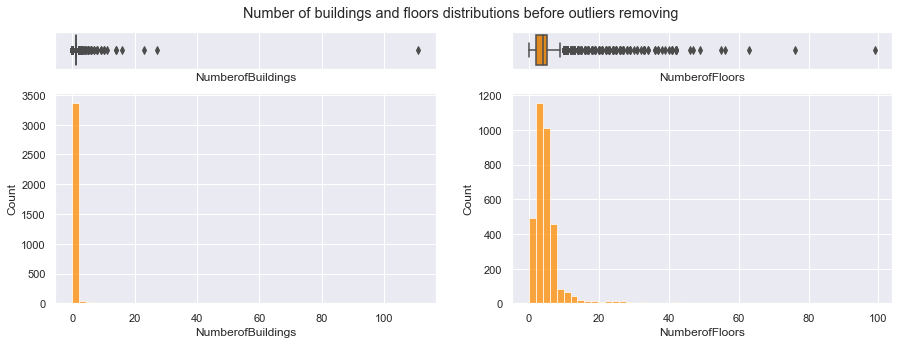

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,5), sharex="col", gridspec_kw={"height_ratios": (.15, .85)})
fig.suptitle("Number of buildings and floors distributions before outliers removing", y=0.95)
sns.boxplot(x=data_exploration['NumberofBuildings'], ax=axes[0][0], color=MAIN_CHART_COLOR)
sns.boxplot(x=data_exploration['NumberofFloors'], ax=axes[0][1], color=MAIN_CHART_COLOR)
sns.histplot(x=data_exploration['NumberofBuildings'], bins=50, ax=axes[1][0], color=MAIN_CHART_COLOR)
sns.histplot(x=data_exploration['NumberofFloors'], bins=50, ax=axes[1][1], color=MAIN_CHART_COLOR)

<AxesSubplot:xlabel='NumberofFloors', ylabel='Count'>

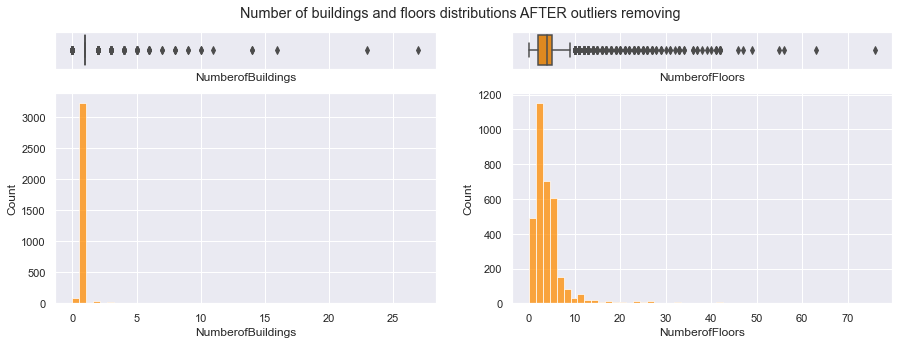

In [20]:
work_data = data_exploration.copy()
work_data = work_data[(work_data['NumberofBuildings'] <= 80) & (work_data['NumberofFloors'] <= 76)]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,5), sharex="col", gridspec_kw={"height_ratios": (.15, .85)})
fig.suptitle("Number of buildings and floors distributions AFTER outliers removing", y=0.95)
sns.boxplot(x=work_data['NumberofBuildings'], ax=axes[0][0], color=MAIN_CHART_COLOR)
sns.boxplot(x=work_data['NumberofFloors'], ax=axes[0][1], color=MAIN_CHART_COLOR)
sns.histplot(x=work_data['NumberofBuildings'], bins=50, ax=axes[1][0], color=MAIN_CHART_COLOR)
sns.histplot(x=work_data['NumberofFloors'], bins=50, ax=axes[1][1], color=MAIN_CHART_COLOR)

### Total building size (GFA)

<AxesSubplot:xlabel='PropertyGFATotal', ylabel='Count'>

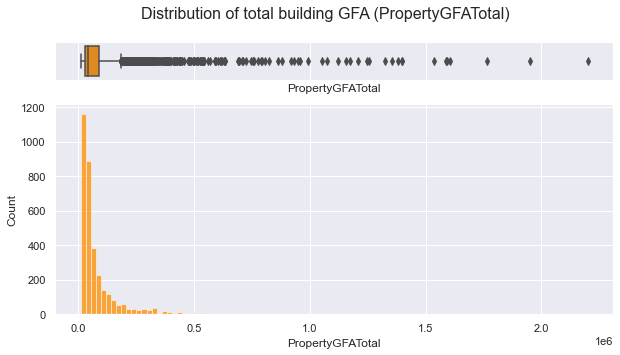

In [21]:
# Removing outliers from number of buildings/floors
work_data = data_exploration[(data_exploration['NumberofBuildings'] <= 80) & (data_exploration['NumberofFloors'] <= 76)]

fig, axes = plt.subplots(nrows=2, figsize=(10,5), sharex="col", gridspec_kw={"height_ratios": (.15, .85)})
fig.suptitle("Distribution of total building GFA (PropertyGFATotal)", fontsize=16)
sns.boxplot(x=work_data['PropertyGFATotal'], ax=axes[0], color=MAIN_CHART_COLOR)
sns.histplot(x=work_data['PropertyGFATotal'], bins=100, ax=axes[1], color=MAIN_CHART_COLOR)

### Parking & Building size (GFA)

<AxesSubplot:xlabel='PropertyGFAParking', ylabel='Count'>

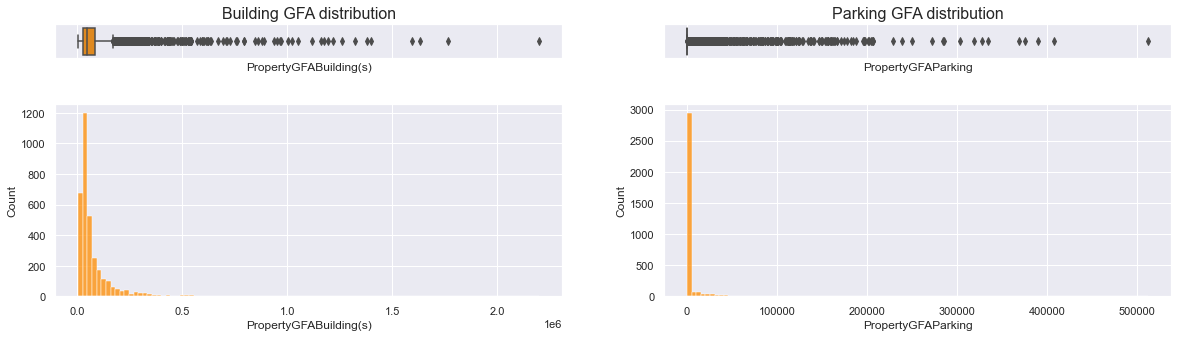

In [22]:
# Removing outliers from number of buildings/floors
work_data = data_exploration[(data_exploration['NumberofBuildings'] <= 80) & (data_exploration['NumberofFloors'] <= 76)]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,5), sharex="col", gridspec_kw={"height_ratios": (.15, .85)})
fig.subplots_adjust(hspace=0.4, wspace=0.2)

axes[0][0].set_title("Building GFA distribution", fontsize=16)
sns.boxplot(x=work_data['PropertyGFABuilding(s)'], ax=axes[0][0], color=MAIN_CHART_COLOR)
sns.histplot(x=work_data['PropertyGFABuilding(s)'], bins=100, ax=axes[1][0], color=MAIN_CHART_COLOR)

axes[0][1].set_title("Parking GFA distribution", fontsize=16)
sns.boxplot(x=work_data['PropertyGFAParking'], ax=axes[0][1], color=MAIN_CHART_COLOR)
sns.histplot(x=work_data['PropertyGFAParking'], bins=100, ax=axes[1][1], color=MAIN_CHART_COLOR)

### GPS Coordinates
Here we just want to check that there is no outliers in the latitude/longitude coordinates.
Some points seem to be apart, but the coordinates are still in the Seattle city so we will keep them.

Text(0.5, 1.0, 'Distribution of GPS longitude')

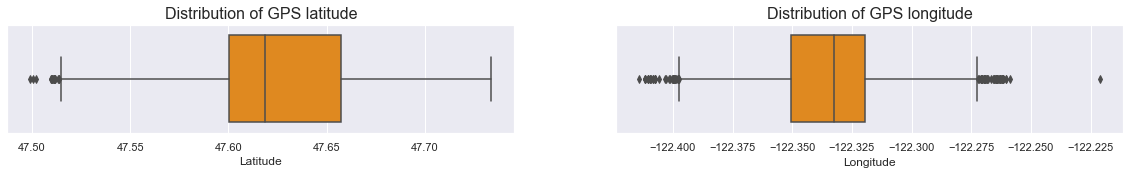

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(20,2))
data_exploration['Latitude'] = pd.to_numeric(data_exploration['Latitude'])
data_exploration['Longitude'] = pd.to_numeric(data_exploration['Longitude'])

sns.boxplot(x=data_exploration['Latitude'], ax=axes[0], color=MAIN_CHART_COLOR)
axes[0].set_title("Distribution of GPS latitude", fontsize=16)

sns.boxplot(x=data_exploration['Longitude'], ax=axes[1], color=MAIN_CHART_COLOR)
axes[1].set_title("Distribution of GPS longitude", fontsize=16)

<a name="2.3"></a>
## 2.3 Targets univariate analysis
The 2 outputs variables seems to possess a lot of outliers.
But when we go into the dataset to check which buildings have such big GHG emissions and energy use, it seems to be normal. They are almost all huge buildings like hospitals, universities, and factories like the boeing one.

Text(0.5, 1.0, 'Distribution of site energy use')

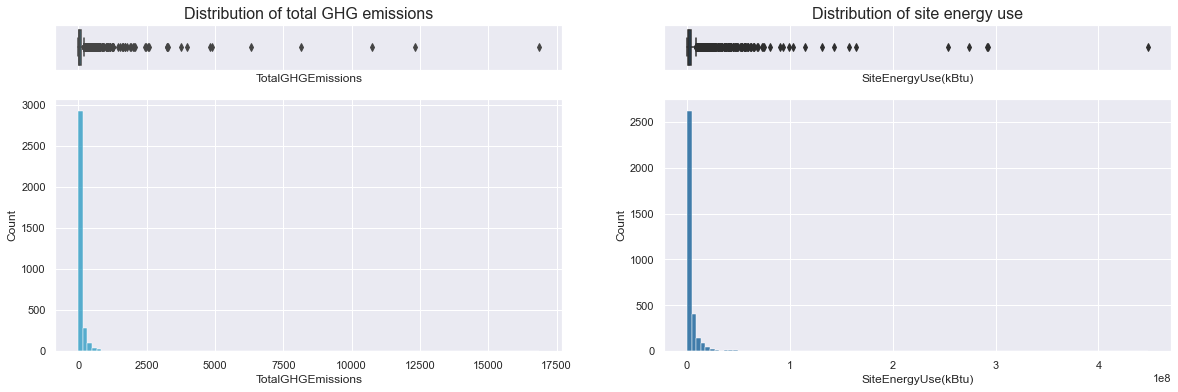

In [24]:
# Removing outliers from number of buildings/floors
work_data = data_exploration[(data_exploration['NumberofBuildings'] <= 80) & (data_exploration['NumberofFloors'] <= 76)]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,6), sharex="col", gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=work_data['TotalGHGEmissions'], color=TARGET_COLORS[0], ax=axes[0][0])
sns.histplot(data=work_data['TotalGHGEmissions'], bins=100, color=TARGET_COLORS[0], ax=axes[1][0])
axes[0][0].set_title('Distribution of total GHG emissions', fontsize=16)

sns.boxplot(x=work_data['SiteEnergyUse(kBtu)'], color=TARGET_COLORS[1], ax=axes[0][1])
sns.histplot(data=work_data['SiteEnergyUse(kBtu)'], bins=100, color=TARGET_COLORS[1], ax=axes[1][1])
axes[0][1].set_title('Distribution of site energy use', fontsize=16)

<a name="2.4"></a>
## 2.4 Multivariate analysis

### Defining features and targets to keep

In [25]:
data_multiv_exploration = manage_existing_features(data)

### Correlation matrix

<AxesSubplot:>

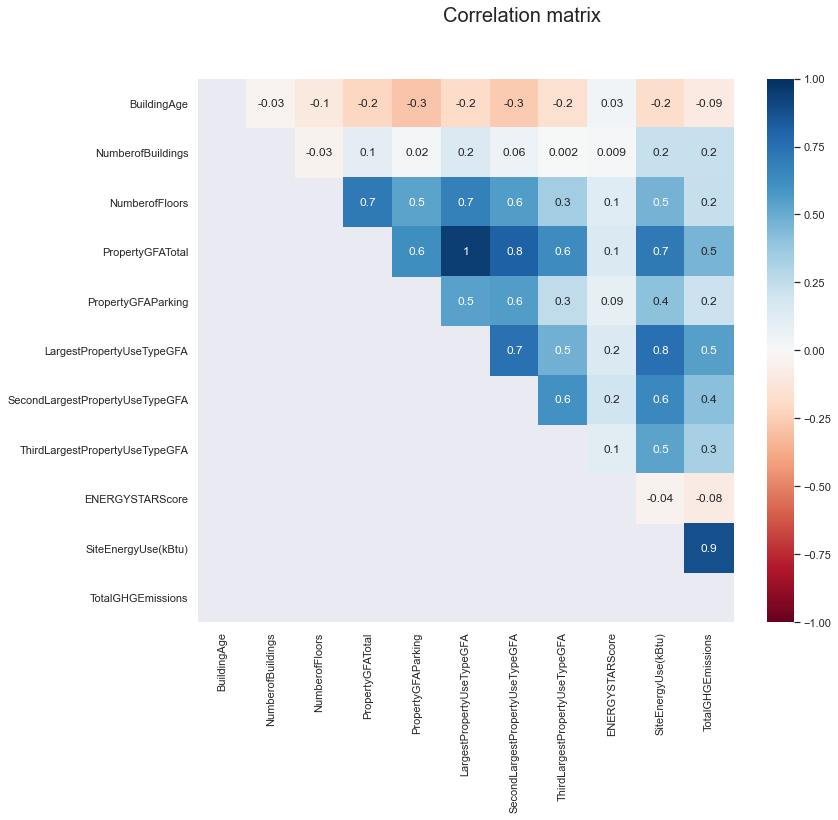

In [26]:
correlation_matrix = data_multiv_exploration.corr(method='pearson')
triangular_matrix = np.tril(correlation_matrix)

fig, ax = plt.subplots(figsize=(12,10))
fig.suptitle("Correlation matrix", fontsize=20)
sns.heatmap(correlation_matrix, annot=True, fmt='.1g', mask=triangular_matrix, vmin=-1, vmax=1, cmap= 'RdBu')

### Pairploting for output features

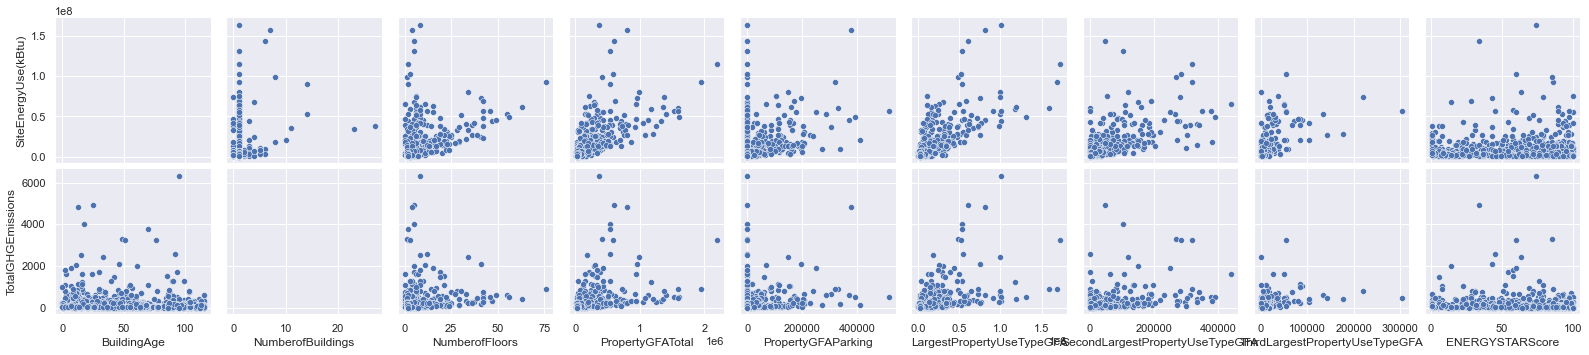

In [27]:
# Preparing features we want to pairplot
x_features = get_targets()
y_features = data_multiv_exploration.dtypes.where(lambda x: (x == 'int64') | (x == 'float64')).dropna().index.tolist()

# Removing y features from x ones
y_features = [feature for feature in y_features if (feature not in x_features)]

pairplot = sns.pairplot(data_multiv_exploration,
                        x_vars=y_features,
                        y_vars=x_features)

### Correlation between PrimaryPropertyType and LargestPropertyUseType
According to the chi-2 test and its p-value, these 2 data are correlated.

In [28]:
def show_qualitative_variables_dependency(data, column_x, column_y, cmap='Blues', title=None, xtick_rotation=45, figsize=(15,10)):
    '''
    Plot the contingency heatmap of the 2 columns and calculate the chi-2 test values
    :param data: the DataFrame containing the 2 columns
    :param column1: X column
    :param column2: Y column
    :return: Plot the heatmap and print the chi-2 results
    '''
    # Contingency table
    crosstab = pd.crosstab(data[column_y], data[column_x])

    st_chi2, st_p, st_dof, st_exp = chi2_contingency(crosstab)
    print('chi-2 result = ' + str(st_chi2))
    print('chi-2 p-value = ' + str(st_p))
    print('chi-2 DOF = ' + str(st_dof))

    plt.figure(figsize=figsize)
    plt.title(title, fontsize=16)
    hm = sns.heatmap(crosstab, annot=True, cmap=cmap, fmt='g')
    hm.set_xticklabels(hm.get_xticklabels(), rotation=xtick_rotation)

chi-2 result = 26307.603747035922
chi-2 p-value = 0.0
chi-2 DOF = 504


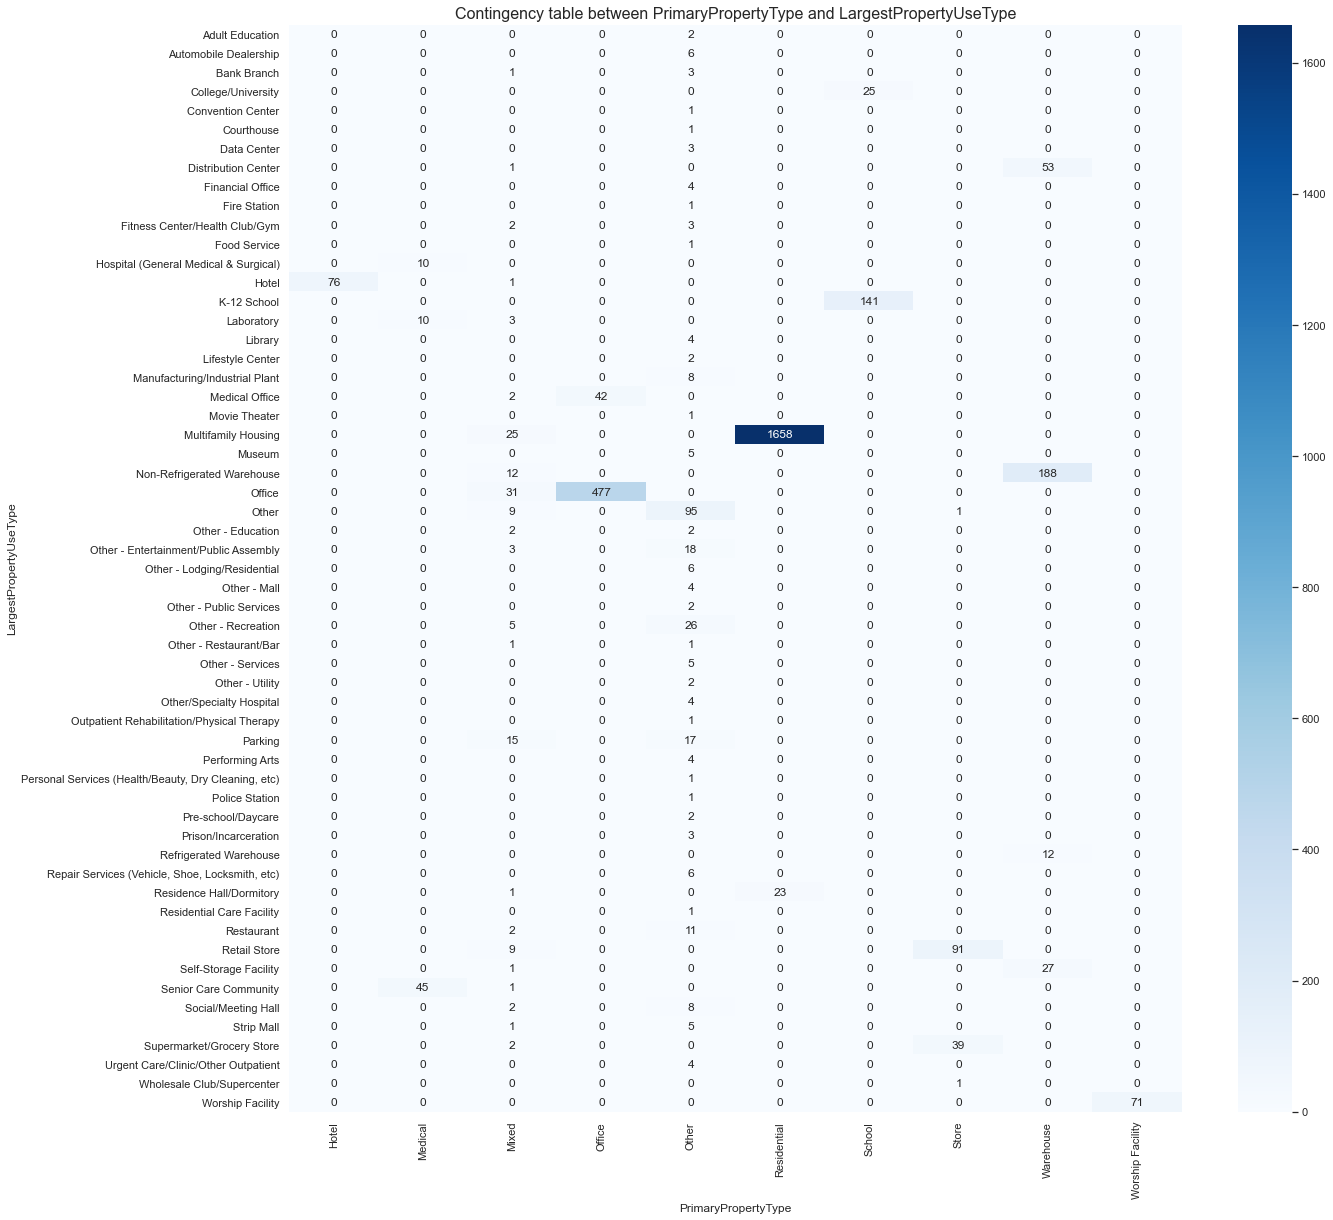

In [29]:
show_qualitative_variables_dependency(data,
                                      column_x='PrimaryPropertyType',
                                      column_y='LargestPropertyUseType',
                                      title="Contingency table between PrimaryPropertyType and LargestPropertyUseType",
                                      xtick_rotation=90,
                                      figsize=(20,20))

The `LargestPropertyUseType` feature won't be kept because it create too many categories with not enough data, and will downgrade our model.

### Correlation between street type and targets

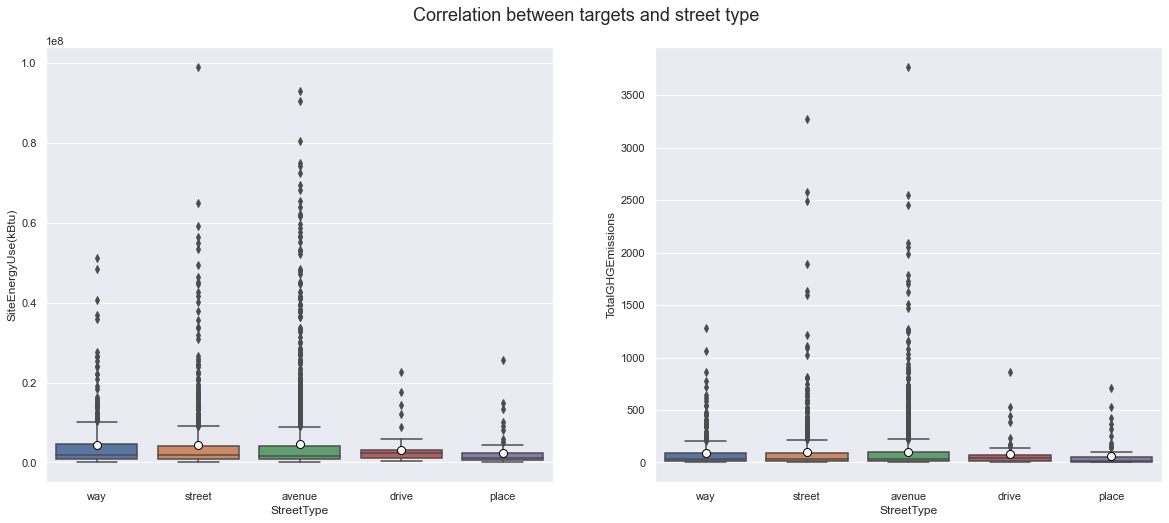

In [30]:
targets = get_targets()
target_street_types_data = data_exploration[targets + ['StreetType']]

# We remove the outliers for a better visibility of the boxplots
target_street_types_data = target_street_types_data[target_street_types_data[targets[0]] < 100000000]

fig, axes = plt.subplots(figsize=(20,8), ncols=2)
fig.suptitle("Correlation between targets and street type", fontsize=18, y=0.95)
for target_index in range(len(targets)):
    sns.boxplot(x=target_street_types_data['StreetType'],
                y=target_street_types_data[targets[target_index]],
                ax=axes[target_index],
                showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                           "markersize":"8"})

### Energy use by primary property type

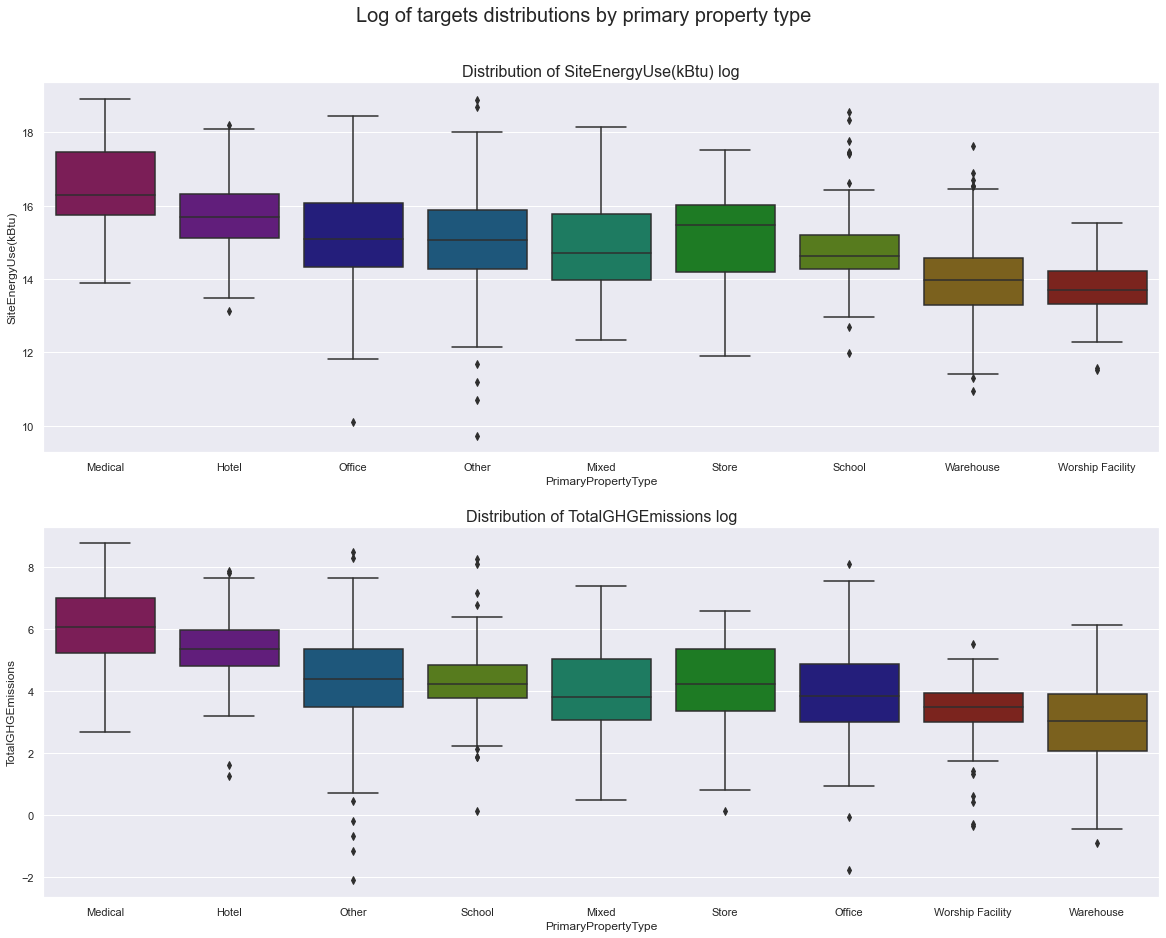

In [31]:
work_data = data_multiv_exploration.copy()
work_data[targets] = np.log(work_data[targets])

mean_data = data_multiv_exploration.copy()
mean_data = mean_data[targets + ['PrimaryPropertyType']].groupby('PrimaryPropertyType').mean().sort_values(by=targets[0])

# Fixing color between the two figures
seaborn_hexa_colors = sns.hls_palette(len(mean_data), l=.3, s=.8).as_hex(); 
mean_data['color'] = seaborn_hexa_colors[:len(mean_data)]

fig, axes = plt.subplots(figsize=(20,15), nrows=2)
fig.suptitle('Log of targets distributions by primary property type', fontsize=20, y=0.95)

for target_index in range(len(targets)):
    axes[target_index].set_title("Distribution of " + targets[target_index] + ' log', fontsize=16)
    mean_data = mean_data.sort_values(by=targets[target_index], ascending=False)
    sns.boxplot(data=work_data[targets + ['PrimaryPropertyType']], 
                 y=targets[target_index], 
                 x='PrimaryPropertyType',
                 palette=mean_data['color'],
                 order=mean_data.index,
                 ax=axes[target_index])

The next steps of the project (preprocessing and modeling) are defined in the second notebook.